# Working with Databases and SQL

## Import Required Libraries

In [31]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

## Create connection to database and cursor object

In [33]:
conn = sqlite3.connect('oil_reservoir.db')
cursor = conn.cursor()

## Create the table from database

In [35]:
cursor.execute('''
CREATE TABLE IF NOT EXISTS wells (
    well_id INTEGER PRIMARY KEY,
    location TEXT,
    depth REAL,
    production_rate REAL,
    production_date DATE
)
''')

cursor.execute('''
CREATE TABLE IF NOT EXISTS reservoirs (
    reservoir_id INTEGER PRIMARY KEY,
    name TEXT,
    rock_type TEXT,
    pressure REAL,
    permeability REAL
)
''')

cursor.execute('''
CREATE TABLE IF NOT EXISTS production_data (
    production_id INTEGER PRIMARY KEY,
    well_id INTEGER,
    production_rate REAL,
    date DATE,
    FOREIGN KEY (well_id) REFERENCES wells (well_id)
)
''')

# Commit the changes
conn.commit()

## Input data into the table

In [37]:
# Insert some sample well data
cursor.executemany('''
INSERT INTO wells (well_id, location, depth, production_rate, production_date)
VALUES (?, ?, ?, ?, ?)
''', [
    (1, 'Gulf of Mexico', 3000, 500, '2023-01-01'),
    (2, 'North Sea', 2500, 400, '2023-01-05'),
    (3, 'Gulf of Mexico', 3500, 600, '2023-01-10'),
    (4, 'North Sea', 2800, 450, '2023-01-15'),
    (5, 'Gulf of Mexico', 3200, 550, '2023-01-20')
])

# Insert some sample reservoir data
cursor.executemany('''
INSERT INTO reservoirs (reservoir_id, name, rock_type, pressure, permeability)
VALUES (?, ?, ?, ?, ?)
''', [
    (1, 'Reservoir A', 'Sandstone', 4000, 100),
    (2, 'Reservoir B', 'Limestone', 3500, 120),
])

# Insert some sample production data
cursor.executemany('''
INSERT INTO production_data (well_id, production_rate, date)
VALUES (?, ?, ?)
''', [
    (1, 500, '2023-01-01'),
    (1, 510, '2023-01-02'),
    (2, 400, '2023-01-05'),
    (3, 600, '2023-01-10'),
    (4, 450, '2023-01-15'),
    (5, 550, '2023-01-20')
])

# Commit the changes
conn.commit()


IntegrityError: UNIQUE constraint failed: wells.well_id

## Query the table using SQL

In [27]:
# Query to get all wells and their production rates
query = "SELECT well_id, location, depth, production_rate FROM wells"
wells_df = pd.read_sql(query, conn)
wells_df


,well_id,location,depth,production_rate
0,1,Gulf of Mexico,3000.0,500.0
1,2,North Sea,2500.0,400.0
2,3,Gulf of Mexico,3500.0,600.0
3,4,North Sea,2800.0,450.0
4,5,Gulf of Mexico,3200.0,550.0


In [29]:
wells_df.describe()

,well_id,depth,production_rate
count,5.000000,5.000000,5.000000
mean,3.000000,3000.000000,500.000000
std,1.581139,380.788655,79.056942
min,1.000000,2500.000000,400.000000
25%,2.000000,2800.000000,450.000000
50%,3.000000,3000.000000,500.000000
75%,4.000000,3200.000000,550.000000
max,5.000000,3500.000000,600.000000


In [39]:
# Query to get average production rate by location
query = '''
SELECT location, AVG(production_rate) AS avg_production
FROM wells
GROUP BY location
'''
avg_production_df = pd.read_sql(query, conn)
avg_production_df


,location,avg_production
0,Gulf of Mexico,550.0
1,North Sea,425.0


In [41]:
# Query to join wells and production data and track production over time
query = '''
SELECT wells.well_id, wells.location, production_data.date, production_data.production_rate
FROM wells
JOIN production_data ON wells.well_id = production_data.well_id
ORDER BY production_data.date
'''
production_df = pd.read_sql(query, conn)
production_df.head()


,well_id,location,date,production_rate
0,1,Gulf of Mexico,2023-01-01,500.0
1,1,Gulf of Mexico,2023-01-02,510.0
2,2,North Sea,2023-01-05,400.0
3,3,Gulf of Mexico,2023-01-10,600.0
4,4,North Sea,2023-01-15,450.0


## Create a Bar plot of Average Production Rate

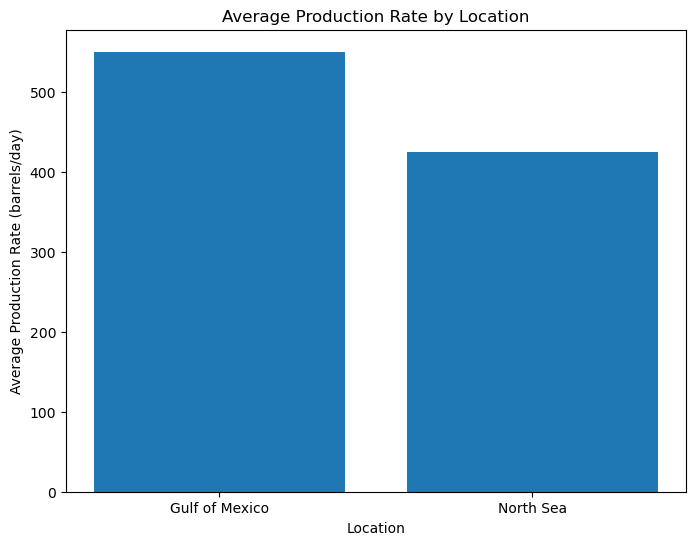

In [43]:
# Bar plot for average production by location
plt.figure(figsize=(8, 6))
plt.bar(avg_production_df['location'], avg_production_df['avg_production'])
plt.title('Average Production Rate by Location')
plt.xlabel('Location')
plt.ylabel('Average Production Rate (barrels/day)')
plt.show()


## Create a Line plot of production rate

/Users/taiwoariyo/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/taiwoariyo/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/taiwoariyo/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/taiwoariyo/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping w

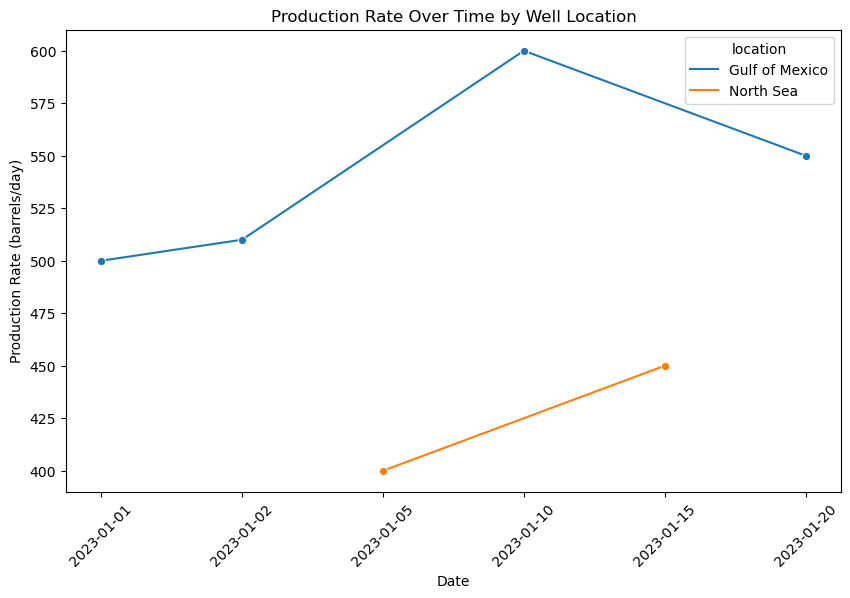

In [45]:
import seaborn as sns

# Line plot for production rate over time by well
plt.figure(figsize=(10, 6))
sns.lineplot(data=production_df, x='date', y='production_rate', hue='location', marker='o')
plt.title('Production Rate Over Time by Well Location')
plt.xlabel('Date')
plt.ylabel('Production Rate (barrels/day)')
plt.xticks(rotation=45)
plt.show()


In [47]:
# Close the connection when done
conn.close()
